Aim - Generate input files for the MITgcm runs. 

The update in this run from the previous ones is that we will make sure the wind is zero in the 50km band near the walls. 

Also, the goal of these series is that will take the 20km run as the base case and run it for 100 years, untill equilibration. Then use its instananeous final output for getting the 5km run, and then step down to 1.25 etc. 

This helps in particulare with the equilibration of the temperature field rapidly, which seems to the slowest equilibrating feature. 

Also, realizing that the long spin up runs that are present on Habanero (have been transferred over to sverdrup), mostly were run with the old forcing. 


In [2]:
import numpy as np
import xarray as xr
from xmitgcm import open_mdsdataset
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
#data_dir = '/data/scratch/rpa/channel_topography/data_old/taux1000_rb0110_bump/'

#grid_dir = '/data/scratch/rpa/channel_topography/run_taux2000_rb0110_bump/'
#
#ds = open_mdsdataset(data_dir, grid_dir, iters=[7257600], delta_t=300,
#                     ignore_unknown_vars=True, geometry='cartesian')

In [3]:
res = 5

In [4]:
output_dir = '/swot/SUM05/dbalwada/input_files_channel_sin2_buffer/%02d' %res + 'km_res/'
tp = '>f8'
output_dir

'/swot/SUM05/dbalwada/input_files_channel_sin2_buffer/05km_res/'

# Topography has the form:

$$ -H + h_b = -H + h_0 e^{-x^2/\sigma^2} $$

With $H = 3000$ m, $h_0 = 1000$ m and $\sigma = 75$ km.

The particular numbers are chosen to match Ryan's previous experiments

In [5]:
# A function that makes xy grid
def make_grid_xy(n, length=2e6):
    lx, ly = length, length
    nx, ny = n, n
    dx, dy = lx/nx, ly/ny

    # create mesh-grids for cell centers
    xc, yc = np.meshgrid(
                dx * np.arange(nx) + dx/2,
                dy * np.arange(ny) + dy/2)
    
    return xc, yc

In [6]:
Lx = 2e6

n = int(Lx/res/1000)

# check that this is the same as the model uses
#np.testing.assert_allclose(xc[0], ds.XC.values)
#np.testing.assert_allclose(yc[:,0], ds.XC.values)
n

400

In [9]:
xc, yc = make_grid_xy(n, Lx)

dx = xc[0,1] - xc[0,0]
dy = yc[1,0] - yc[0,0]
#print dx, dy    , len(xc[0,:])

In [72]:
H = 3000.0 
h0 = 1000.0
sig = 75.0e3

# flat
#bathy = -(H + h)

# flat with merigional gaussian ridge
bathy = H - h0 * np.exp(-(xc - Lx/2)**2 / sig**2)

# Gaussian ridge and sloping bottom
#bathy =  -(H-  h0*np.exp(-(xc - Lx/2)**2 / sig**2)
#           - 10**(-3)*(yc-1000e3)*np.sign(yc-1000e3)*(1-np.exp(-(xc - Lx/2)**2 / sig**2) ))

# set south boundary to zero - this make the domain non-peridic in y direction.
bathy[0,:] = 0.0


In [76]:
# save to file 
bathy.astype(tp).tofile(output_dir + 'BATHY_3000m_ridge_3_slope_1000m_75m_wide%03d.bin' % res)

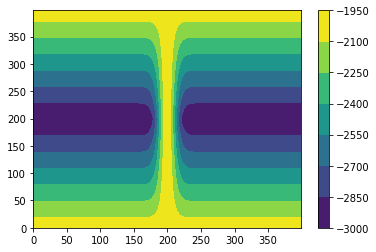

In [73]:
plt.contourf((bathy[1:,:]), vmax=-2000)
plt.colorbar()

# Define the wind conditions

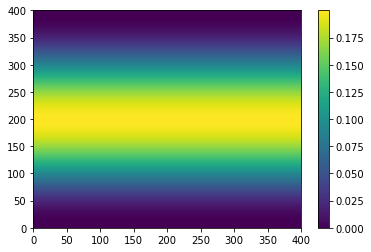

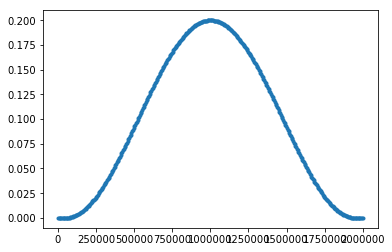

In [11]:
tau0 = 0.2

# make sure that the northern point has zero winds
tau = np.zeros([n,n])

# the wind profile in now sin^2, it was sin in Abernathey's old papers
a =100e3 # the narrowness of the 
L =2000e3
tau = tau0*(np.sin(np.pi* (yc-a/2)/(L-a))**2) # slightly squeezed wind profile to account 

tau[yc<=a/2] = 0.
tau[yc>=(L-a/2)] = 0.

tau.astype(tp).tofile((output_dir + 'TAU_sin2_with_zeros_for50km_%03d_%03d.bin'%(tau0*1e4,res)))

flag = 1
if flag ==1 :
    plt.pcolor(tau)
    plt.colorbar()

    plt.figure()
    plt.plot(yc[:,n/2],tau[:,n/2],'.')
    
    

# Define the surface restoring conditions 


In [12]:
Tmin, Tmax = 0., 8.0
Tsurf = np.tile(np.linspace(Tmin, Tmax, n), (n,1)).T

Tsurf.astype(tp).tofile((output_dir + 'THETA_surf_0to8_linear_%03d.bin' %res))

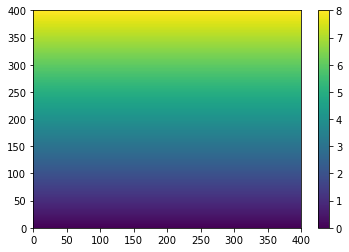

In [13]:
flag = 1
if flag == 1:
    plt.pcolor(Tsurf)
    plt.colorbar()

# Below this the code interpolates the model output to a different grid

In [3]:
# this is the vertical grid from LLC, modified to be 100 m deep 
# (76 levels, original llc has 100 and goes deeper).

delR =   np.array([1.00,    1.14,    1.30,    1.49,   1.70,  
                   1.93,    2.20,    2.50,    2.84,   3.21,        
                   3.63,    4.10,    4.61,    5.18,   5.79,   
                   6.47,    7.20,    7.98,    8.83,   9.73,  
                   10.69,   11.70,   12.76,   13.87,  15.03,   
                   16.22,   17.45,   18.70,   19.97,  21.27,    
                   22.56,   23.87,   25.17,   26.46,  27.74,  
                   29.00,   30.24,   31.45,   32.65,  33.82, 
                   34.97,   36.09,   37.20,   38.29,  39.37,   
                   40.45,   41.53,   42.62,   43.73,  44.87,
                   46.05,   47.28,   48.56,   49.93,  51.38,
                   52.93,   54.61,   56.42,   58.38,  60.53,
                   62.87,   65.43,   68.24,   71.33,  74.73,
                   78.47,   82.61,   87.17,   92.21,  97.79,
                   103.96,  110.79,  118.35,  126.73, 136.01, 174.67])

In [9]:
Z = -(delR.cumsum())

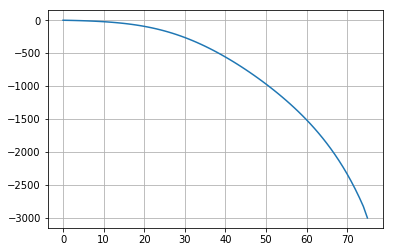

In [10]:
plt.plot(Z)
plt.grid('on')

In [5]:
# get some output from a 20km simulation to use as spin up for 5km simulation

# weak surface restoration
spinup2_dir = '/swot/SUM05/dbalwada/channel_beta/20km/run_spinup_2/'
ds_20 = open_mdsdataset(spinup2_dir, iters = [5184000],delta_t=1200, prefix=['T']
                     ,ignore_unknown_vars=True, geometry='cartesian')
# strong surface restoration (this is what we want to use.)
# we had originally forgotten to adjust surface restoration time scale with dz. 
# we want to keep dz/tau (piston velocity of teperature) to a constant if changing vertical grid.
spinup_small_lam_dir = '/swot/SUM05/dbalwada/channel_beta/20km/run_spinup_small_lam/'
ds_20_small_lam = open_mdsdataset(spinup_small_lam_dir, iters = [5184000],delta_t=1200, prefix=['T']
                     ,ignore_unknown_vars=True, geometry='cartesian')

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xmitgcm-0.2.1-py3.5.egg/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xmitgcm-0.2.1-py3.5.egg/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


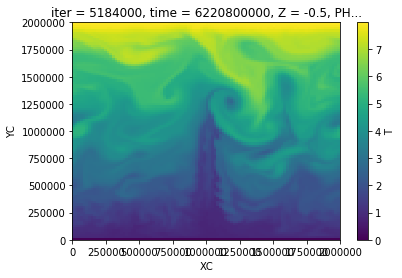

In [6]:
ds_20_small_lam['T'].isel(Z=0).plot()

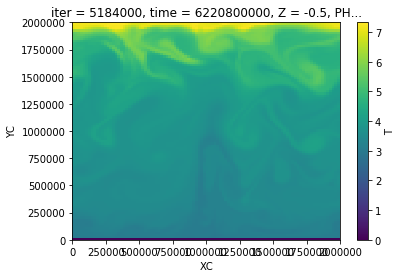

In [7]:
# notice how the range of surface temp is narrower for weaker restoration.
ds_20['T'].isel(Z=0).plot()

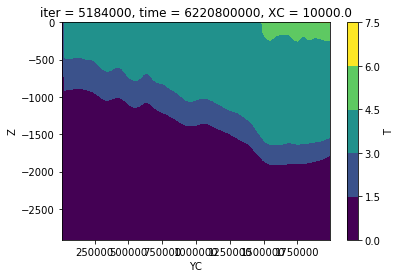

In [8]:
ds_20['T'].isel(XC=0,time=0).plot.contourf()

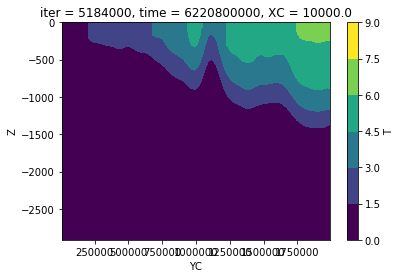

In [13]:
ds_20_small_lam['T'].isel(XC=0,time=0).plot.contourf()

In [9]:
ds20_reshaped = ds_20['T'].isel(time=-1).values


In [14]:
ds20_small_lam_reshaped = ds_20_small_lam['T'].isel(time=-1).values


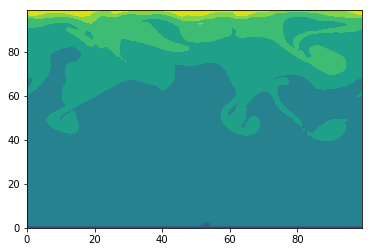

In [10]:
plt.contourf(ds20_reshaped[0,:,:])

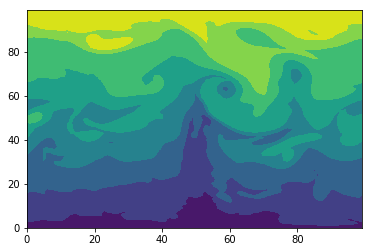

In [15]:
plt.contourf(ds20_small_lam_reshaped[0,:,:])

In [16]:
# the code below this interpolates 20km to 5km grid.
xn, yn = xc, yc       # new grid
xo, yo = np.meshgrid(ds_20_small_lam.XC.values, ds_20_small_lam.YC.values) # old grid

In [18]:
# create an extended matrix
# add extra points to both side of the domain that 
# sit at the farthest edge

xtemp = xo[0,:]
xtemp2 = np.zeros([len(xtemp)+2])
xtemp2[1:(len(xtemp2)-1)] = xtemp
xtemp2[-1] = Lx


ytemp = yo[:,0]
ytemp2 = np.zeros([len(ytemp)+2])
ytemp2[1:(len(ytemp2)-1)] = ytemp
ytemp2[-1]=Lx

xo2, yo2 = np.meshgrid(xtemp2, ytemp2)

In [20]:
hydro_reshaped_pad = np.zeros([76, len(ytemp)+2, len(xtemp)+2])

hydro_reshaped_pad[:,1:len(ytemp)+1,1:len(xtemp)+1] = ds20_small_lam_reshaped

hydro_reshaped_pad[:,:,0] = hydro_reshaped_pad[:,:,1]
hydro_reshaped_pad[:,:,-1] = hydro_reshaped_pad[:,:,1]
hydro_reshaped_pad[:,0,:] = hydro_reshaped_pad[:,1,:]
hydro_reshaped_pad[:,-1,:] = hydro_reshaped_pad[:,-3,:]
hydro_reshaped_pad[:,-2,:] = hydro_reshaped_pad[:,-3,:]

In [22]:
from scipy.interpolate import LinearNDInterpolator, NearestNDInterpolator
new_temp = np.zeros((76,len(yn[:,0]),len(xn[0,:])))

In [23]:
for klev in range(0, 76):
    
    data = hydro_reshaped_pad[klev,:,:]

    points = np.vstack((yo2.ravel(), xo2.ravel())).T
    values = data.ravel()
    lint = LinearNDInterpolator(points, values)

    new_points = np.vstack((yn.ravel(), xn.ravel())).T

    new_values = lint(new_points)
    
    new_temp[klev,:,:] = new_values.reshape(xn.shape)
    print(klev)

    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75


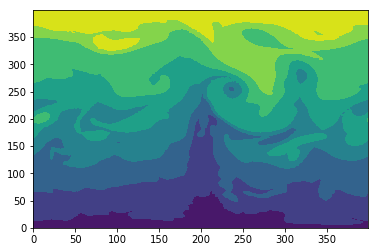

In [24]:
# check if interpolation worked.
plt.contourf(new_temp[0,:,:])

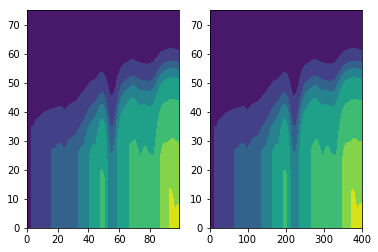

In [26]:
plt.subplot(121)
plt.contourf(ds20_small_lam_reshaped[:,:,0])
plt.subplot(122)
plt.contourf(new_temp[:,:,0] )

In [28]:
# we ensure to add a small temperature to the interpolated data.
# MITgcm has a flag to check that no temperature cell is exactly 0C.
# if exact 0s are found then MITgcm will not run.

new_temp=new_temp+0.001

In [29]:
# save file
new_temp.astype(tp).tofile(output_dir + 'THETA_init_20km_small_lam_start_%03d.bin' % res)

# Tracer relax files

In [20]:
# tracer relaxation files for tracer that is restored in the top cell - surface tracer injection. 

rbcs_mask = np.zeros((76,n,n))
rbcs_mask[0,:,:] = 1.
rbcs_mask.astype(tp).tofile(output_dir + 'rbcs_mask_%03d.bin' % res)

rbcs_relax = np.zeros((76,n,n))
rbcs_relax[0,:,:] = 1.
rbcs_relax.astype(tp).tofile(output_dir + 'rbcs_relax_%03d.bin' % res)
